In [59]:
from datetime import datetime
from pathlib import Path

import kmodes
import missingno
import missingpy
import pandas as pd
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

from common.connectors.elastic import ESClient
from common.handlers import csv_read

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
avix = ESClient("dev_realestate.avix_nl_corop_index")

#### Functions

In [4]:
def get_price_index(es: ESClient, municipality_id_filter: list) -> pd.DataFrame:
    """
    This functions queries ES for all the historical price indexes for every
    municipality in the given municipality_id_filter list.
    :param es: AvixES elastic client
    :param municipality_id_filter: List of municipality codes
    :return: pd.DataFrame
    """
    query_condition = " OR ".join([str(n) for n in municipality_id_filter])
    q = {"query": {"bool": {"must": [{"match": {"gemeentecode": query_condition}}]}}}
    result = es.findall(query=q, index="dev_realestate.avix_nl_corop_index")
    # result is of the type list and will be empty if Elastic Search could not find the estate
    if result:
        # Cleaning up results
        result_df = pd.DataFrame(hit["_source"] for hit in result)
        results_df = (result_df
                      .rename(columns={"avix_corop_index": "index", "gemeentecode": "mun_code"})
                      .filter(["index", "mun_code", "year", "quarter"])
                      .astype({"index": float, "mun_code": int}))
        assert 3 in results_df['mun_code'].unique().tolist()
        return results_df


def add_indexed_transactions(es: ESClient, df: pd.DataFrame) -> pd.DataFrame:
    """
    Used for querying historical price indices per municipality, and using these to index the
    historical sale prices to the most recently available index (usually last yearly quarter).
    :param es: AvixES elastic client
    :param df: This needs to be the nearby_estates dataframe
    :return: The original input dataframe, with additional columns "indexed_price" and "indexed_date"
    """
    original_columns = df.columns.tolist()

    # Getting the price indices from ES
    df["mun_code"] = df["mun_code"].astype(int)
    nearby_mun_codes = df['mun_code'].unique().tolist()
    price_indices = get_price_index(es, nearby_mun_codes)
    for mun in nearby_mun_codes:
        _sorted = price_indices[price_indices["mun_code"] == mun].sort_values(["year", "quarter"])
        first = _sorted.iloc[0].tolist()
        last = _sorted.iloc[-1].tolist()
    
    # Preparing dataframes for joining
    price_indices["YQ"] = price_indices['year'] + '-Q' + price_indices['quarter']
    df["YQ"] = df["date"].dt.year.apply(str) + '-Q' + df["date"].dt.quarter.apply(str)
    most_recent_index = price_indices[price_indices["YQ"] == price_indices.groupby("mun_code")["YQ"].transform(max)]
    most_recent_index = most_recent_index.rename(columns={"index": "current_index", "YQ": "indexed_date"})
    most_recent_yq = most_recent_index["indexed_date"].iloc[0]
    
    # If we have sales more recent than the most current indices, we change their YQ to the most recent index so that
    # we index the prices to that quarter. Here we assume that all municipalities have the same most-recent-yq.
    df.loc[df["YQ"] > most_recent_yq, "YQ"] = most_recent_yq
    
    # Joining and doing the indexing calculations
    df_indexed = df.merge(price_indices, on=["YQ", "mun_code"])
    df_indexed = df_indexed.merge(most_recent_index, on="mun_code")
    for key in ("current_index", "amount", "index"):
        if df_indexed[key].dtype == "object":
            df_indexed[key] = df_indexed[key].astype(float)
    df_indexed = df_indexed.assign(indexed_price=lambda x: x["current_index"] * x["amount"] / x["index"])
    df_indexed = df_indexed.filter(original_columns + ["indexed_price", "indexed_date"])
    
    if len(df) - len(df_indexed) > 0:
        print(f"We dropped {len(df) - len(df_indexed)} when joining on price indices!")
        dropped = df.merge(price_indices, on=["YQ", "mun_code"], how="outer").query("quarter != quarter")["YQ"]
        print(f"{len(dropped)} of these were dropped due to missing YQ values: {dropped.unique().tolist()}")

    return df_indexed

#### Data

In [5]:
path = Path.home() / "Google Drive/DDMA Hackathon"
list(path.glob("*.csv"))

[WindowsPath('C:/Users/PSaalbrink/Google Drive/DDMA Hackathon/buurt_data.csv'),
 WindowsPath('C:/Users/PSaalbrink/Google Drive/DDMA Hackathon/complete_hackathon_dataset.csv'),
 WindowsPath('C:/Users/PSaalbrink/Google Drive/DDMA Hackathon/GROENE_DAKEN.csv'),
 WindowsPath('C:/Users/PSaalbrink/Google Drive/DDMA Hackathon/hackathon.csv')]

In [37]:
red_data = [{**d,
             "mun_code": d["Gemeente2019"],
             "buurt_code": d["Buurt2019"].rjust(8, "0"),
             "date": datetime.strptime(d["date"], "%d/%m/%Y")
    } for d in csv_read(path / "hackathon.csv")
           if "2019" in d["date"]]
red_data = pd.DataFrame(red_data).drop(columns=["lon", "lat"])
red_data["date"] = pd.to_datetime(red_data["date"])

cbs_data = [d for d in csv_read(path / "buurt_data.csv")]
cbs_data = pd.DataFrame(cbs_data).drop(columns=["", "postcode"])

data = pd.merge(cbs_data, red_data, left_on="gwb_code_10", right_on="Buurt2019", how="inner")
data.columns = [col.lower() for col in data.columns]
del red_data, cbs_data

In [39]:
float_keys = [
    'mannen',
    'vrouwen',
    '0_tot_15',
    '15_tot_25',
    '25_tot_45',
    '45_tot_65',
    '65_+',
    'ongehuwd',
    'gehuwd',
    'gescheiden',
    'migratieachtergrond',
    'geboorte_relatief',
    'sterfte_relatief',
    'eenpersoonshuishoudens',
    'huishoudens_zonder_kinderen',
    'huishoudens_met_kinderen',
    'gemiddelde_huishoudensgrootte',
    'bevolkingsdichtheid',
    'percentage_eengezinswoning',
    'percentage_meergezinswoning',
    'percentage_bewoond',
    'percentage_onbewoond',
    'koopwoningen',
    'huurwoningen',
    'elektriciteitsverbruik',
    'aardgasverbruik',
    'bedrijfsvestigingen',
    'landbouw_bosbouw_visserij',
    'nijverheid_energie',
    'handel_horeca',
    'vervoer_informatie_communicatie',
    'financiële_diensten_onroerendgoed',
    'zakelijke_dienstverlening',
    'cultuur_recreatie_overige',
    'personenautos_brandstof',
    'personenautos_overige_brandstof',
    'personenautos_huishouden',
    'personenautos_oppervlakte',
    'motorfietsen',
    'oppervlakte',
    'oppervlakte_land',
    'oppervlakte_water',
    'dekkingspercentage',
    'stedelijkheid',
    'omgevingsadressendichtheid',
    'score_totaal_2018',
    'score_woningen_2018',
    'score_bewoners_2018',
    'score_voorzieningen_2018',
    'score_veiligheid_2018',
    'score_omgeving_2018',
    'score_totaal_2012',
    'score_woningen_2012',
    'score_bewoners_2012',
    'score_voorzieningen_2012',
    'score_veiligheid_2012',
    'score_omgeving_2012',
    'score_totaal_ontw',
    'score_woningen_ontw',
    'score_bewoners_ontw',
    'score_voorzieningen_ontw',
    'score_veiligheid_ontw',
    'score_omgeving_ontw',
]

int_keys = [
    'aantal_inwoners',
    'huishoudens',
    'woningvoorraad',
    'personenautos',
    'amount',
    'build_year',
    'use_surface',
    'parcel_surface',
    'number_of_objects',
]

data[int_keys] = data[int_keys].astype(int)
data[float_keys] = data[float_keys].astype(float)

In [40]:
# data.columns.tolist()
# data.head()
# data.dtypes.to_dict()
# data.iloc[0]
# {k: (v, d) for k, v, d in zip(data.columns, data.iloc[0], data.dtypes)}

#### Elastic

In [41]:
data = add_indexed_transactions(avix, data)

In [103]:
test = data.dropna()

TODO:
- ~~column names lowercase~~
- ~~check dtypes~~
- standaardiseren
- missing values imputeren
- missing buurten imputeren

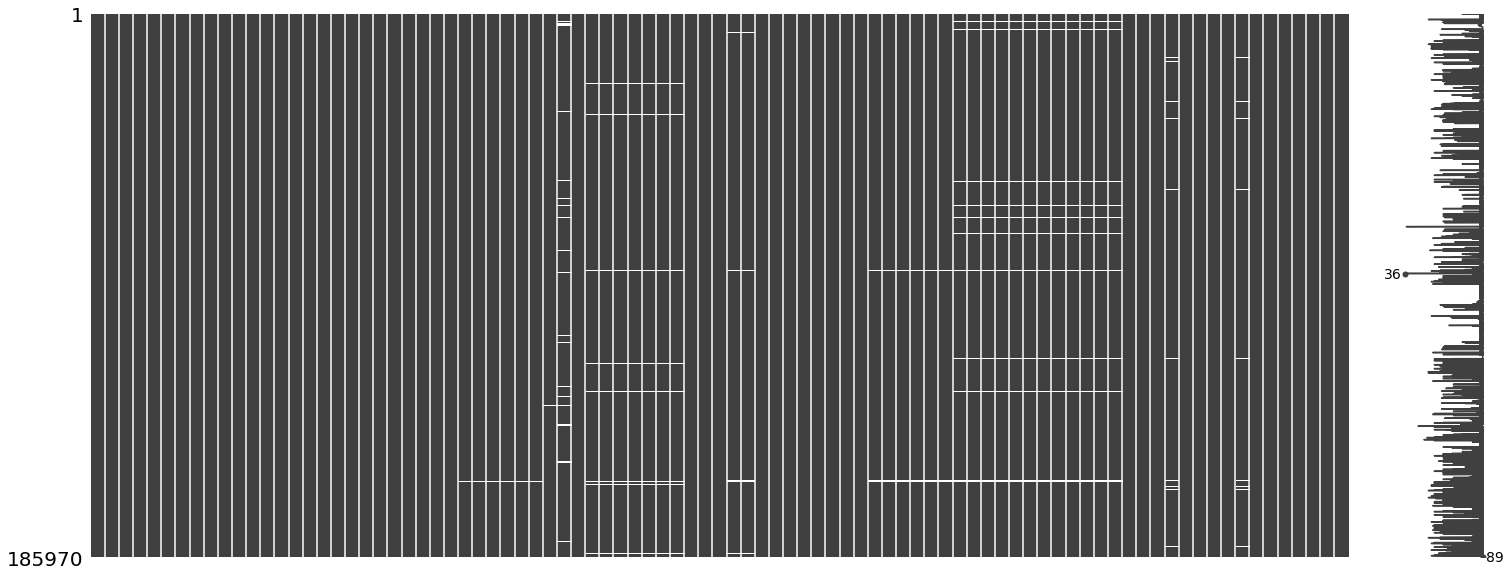

In [33]:
missingno.matrix(data)

8548


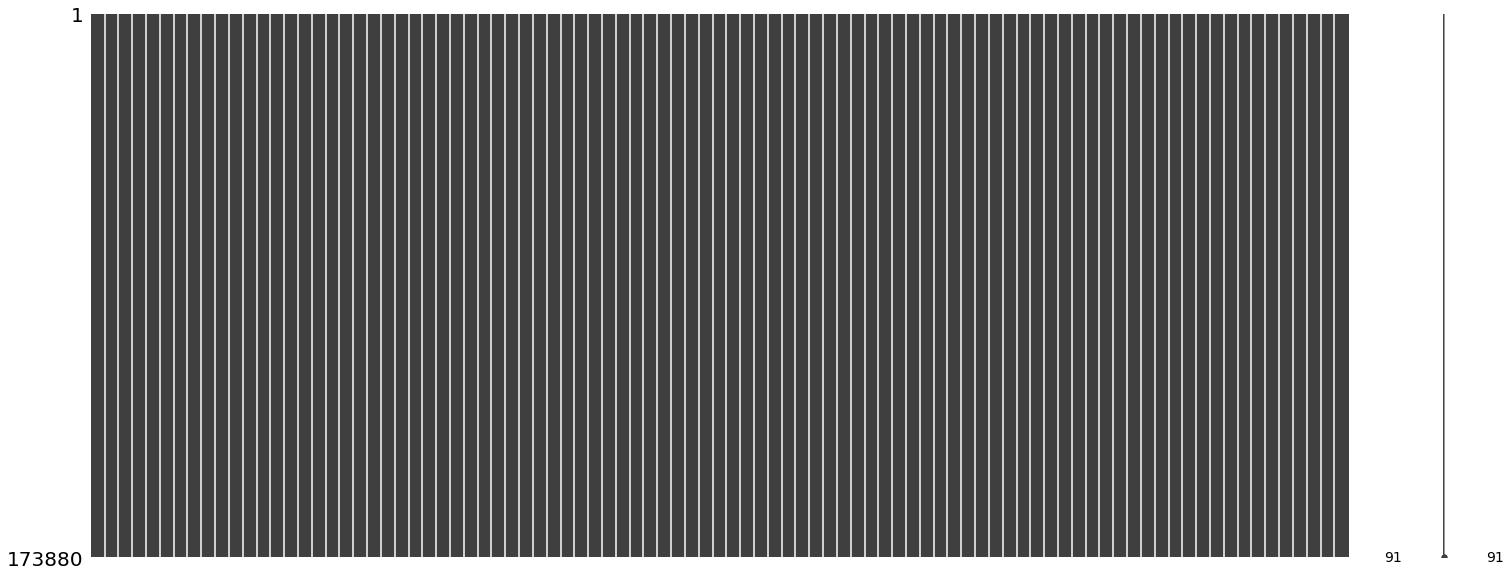

In [69]:
print(len(test.buurt_code.unique().tolist()))
missingno.matrix(test)

#### Scaling

In [54]:
test[float_keys].head()

,mannen,vrouwen,0_tot_15,15_tot_25,25_tot_45,45_tot_65,65_+,ongehuwd,gehuwd,gescheiden,migratieachtergrond,geboorte_relatief,sterfte_relatief,eenpersoonshuishoudens,huishoudens_zonder_kinderen,huishoudens_met_kinderen,gemiddelde_huishoudensgrootte,bevolkingsdichtheid,percentage_eengezinswoning,percentage_meergezinswoning,percentage_bewoond,percentage_onbewoond,koopwoningen,huurwoningen,elektriciteitsverbruik,aardgasverbruik,bedrijfsvestigingen,landbouw_bosbouw_visserij,nijverheid_energie,handel_horeca,vervoer_informatie_communicatie,financiële_diensten_onroerendgoed,zakelijke_dienstverlening,cultuur_recreatie_overige,personenautos_brandstof,personenautos_overige_brandstof,personenautos_huishouden,personenautos_oppervlakte,motorfietsen,oppervlakte,oppervlakte_land,oppervlakte_water,dekkingspercentage,stedelijkheid,omgevingsadressendichtheid,score_totaal_2018,score_woningen_2018,score_bewoners_2018,score_voorzieningen_2018,score_veiligheid_2018,score_omgeving_2018,score_totaal_2012,score_woningen_2012,score_bewoners_2012,score_voorzieningen_2012,score_veiligheid_2012,score_omgeving_2012,score_totaal_ontw,score_woningen_ontw,score_bewoners_ontw,score_voorzieningen_ontw,score_veiligheid_ontw,score_omgeving_ontw
0,0.475584,0.524416,0.097665,0.095541,0.212314,0.303609,0.29087,0.414013,0.360934,0.11465,0.097665,0.006,0.014,0.530769,0.284615,0.184615,1.7,2798.0,53.0,47.0,92.0,8.0,40.0,59.0,2190.0,1370.0,175.0,0.0,15.0,80.0,5.0,10.0,30.0,30.0,0.860465,0.139535,0.8,1275.0,95.0,90.0,84.0,5.0,1.0,3.0,1195.0,-0.051487,0.008156,0.033864,-0.100124,0.012116,-0.005499,-0.021037,0.018074,0.005315,-0.085275,0.040014,0.000834,-0.030451,-0.009918,0.028548,-0.014849,-0.027899,-0.006333
1,0.475584,0.524416,0.097665,0.095541,0.212314,0.303609,0.29087,0.414013,0.360934,0.11465,0.097665,0.006,0.014,0.530769,0.284615,0.184615,1.7,2798.0,53.0,47.0,92.0,8.0,40.0,59.0,2190.0,1370.0,175.0,0.0,15.0,80.0,5.0,10.0,30.0,30.0,0.860465,0.139535,0.8,1275.0,95.0,90.0,84.0,5.0,1.0,3.0,1195.0,-0.051487,0.008156,0.033864,-0.100124,0.012116,-0.005499,-0.021037,0.018074,0.005315,-0.085275,0.040014,0.000834,-0.030451,-0.009918,0.028548,-0.014849,-0.027899,-0.006333
2,0.475584,0.524416,0.097665,0.095541,0.212314,0.303609,0.29087,0.414013,0.360934,0.11465,0.097665,0.006,0.014,0.530769,0.284615,0.184615,1.7,2798.0,53.0,47.0,92.0,8.0,40.0,59.0,2190.0,1370.0,175.0,0.0,15.0,80.0,5.0,10.0,30.0,30.0,0.860465,0.139535,0.8,1275.0,95.0,90.0,84.0,5.0,1.0,3.0,1195.0,-0.051487,0.008156,0.033864,-0.100124,0.012116,-0.005499,-0.021037,0.018074,0.005315,-0.085275,0.040014,0.000834,-0.030451,-0.009918,0.028548,-0.014849,-0.027899,-0.006333
3,0.475584,0.524416,0.097665,0.095541,0.212314,0.303609,0.29087,0.414013,0.360934,0.11465,0.097665,0.006,0.014,0.530769,0.284615,0.184615,1.7,2798.0,53.0,47.0,92.0,8.0,40.0,59.0,2190.0,1370.0,175.0,0.0,15.0,80.0,5.0,10.0,30.0,30.0,0.860465,0.139535,0.8,1275.0,95.0,90.0,84.0,5.0,1.0,3.0,1195.0,-0.051487,0.008156,0.033864,-0.100124,0.012116,-0.005499,-0.021037,0.018074,0.005315,-0.085275,0.040014,0.000834,-0.030451,-0.009918,0.028548,-0.014849,-0.027899,-0.006333
4,0.475584,0.524416,0.097665,0.095541,0.212314,0.303609,0.29087,0.414013,0.360934,0.11465,0.097665,0.006,0.014,0.530769,0.284615,0.184615,1.7,2798.0,53.0,47.0,92.0,8.0,40.0,59.0,2190.0,1370.0,175.0,0.0,15.0,80.0,5.0,10.0,30.0,30.0,0.860465,0.139535,0.8,1275.0,95.0,90.0,84.0,5.0,1.0,3.0,1195.0,-0.051487,0.008156,0.033864,-0.100124,0.012116,-0.005499,-0.021037,0.018074,0.005315,-0.085275,0.040014,0.000834,-0.030451,-0.009918,0.028548,-0.014849,-0.027899,-0.006333


In [104]:
scaler = RobustScaler()
test[int_keys] = scaler.fit_transform(test[int_keys])

C:\Program Files\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Program Files\Python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Saving

In [105]:
# data.to_csv(path / "complete_hackathon_dataset.csv", index=False)
test.to_csv(path / "complete_hackathon_dataset.csv", index=False)